## In this notebook, a model is trained using a csv file that contains user marked spam and ham messages. Then it will take a custom user message to evaluate whether it is spam or ham.

### Importing libraries: Step 1

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [4]:
sms = pd.read_csv('spam.csv',encoding='ISO-8859-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data cleaning: remove unnecessary columns

In [6]:
sms.drop(labels= ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Rename the columns and describe the dataframe

In [7]:
sms.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Make Word clouds of ham and spam messages by firstly creating a string of ham and spam respectively and then using WordCloud library.

In [64]:
ham_msg_text = ' '.join(sms[sms['label'] == 'ham']['message'])
spam_msg_text = ' '.join(sms[sms['label'] == 'spam']['message'])

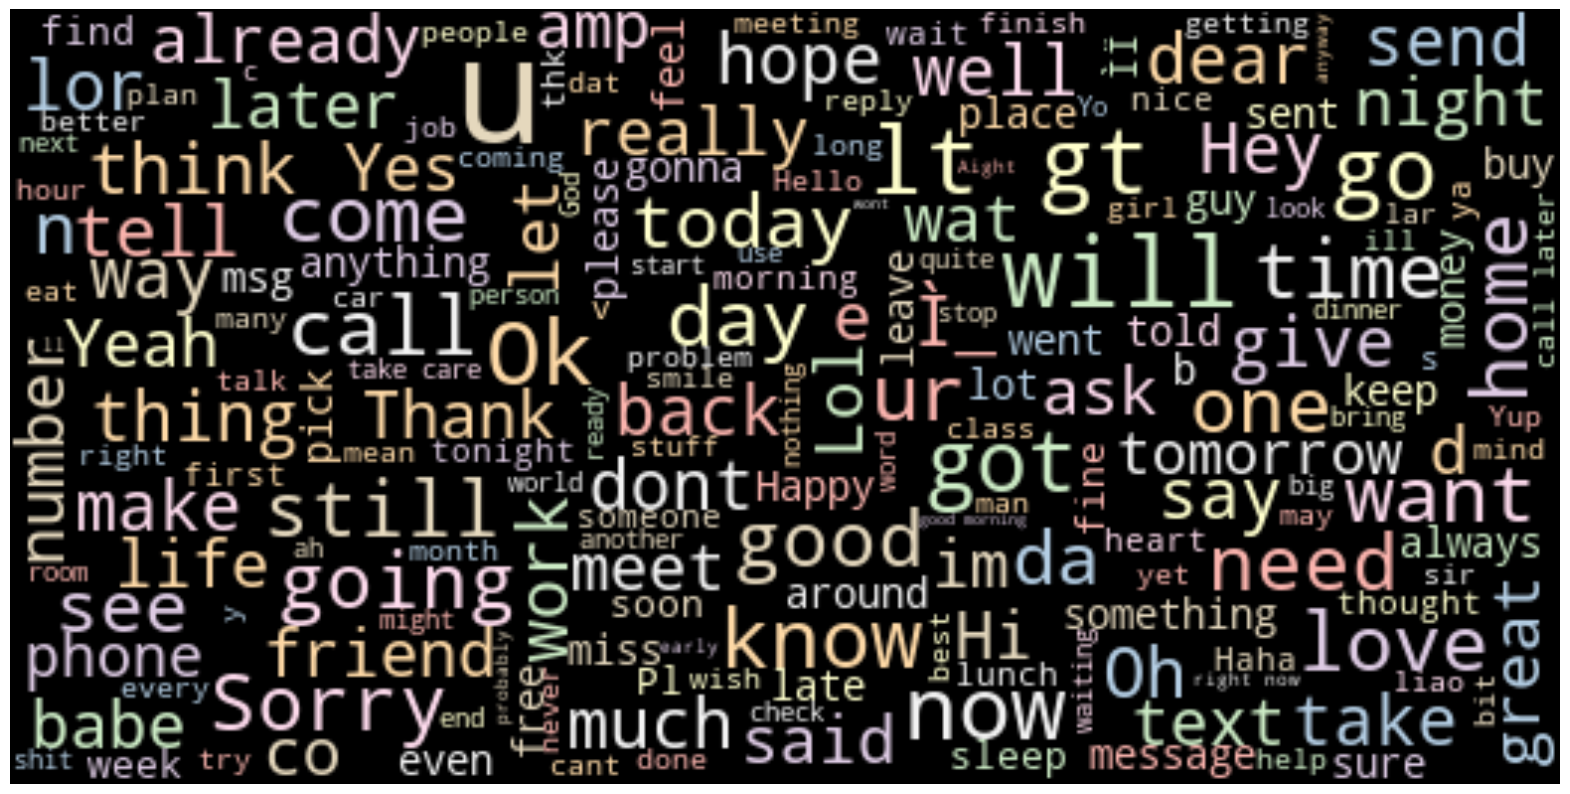

In [67]:
ham_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(ham_msg_text)
plt.figure(figsize=(20,14))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

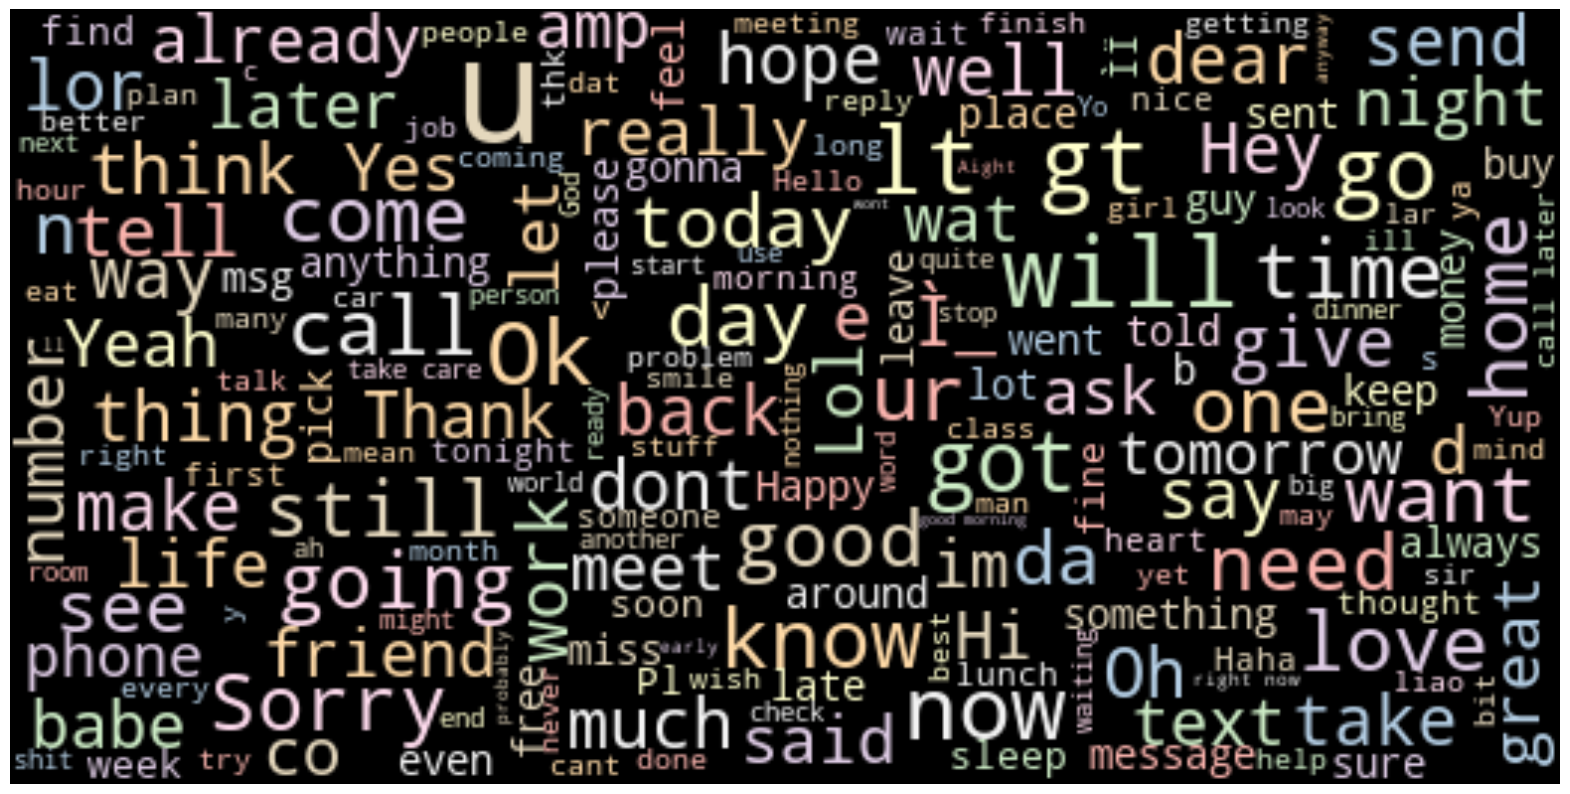

In [68]:
spam_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(spam_msg_text)
plt.figure(figsize=(20,14))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()